In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import tree
from scipy.stats import iqr
from scipy.stats import skew
from scipy.stats import kurtosis
from sklearn.model_selection import GridSearchCV

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import VotingClassifier

import warnings
warnings.filterwarnings('ignore')

In [16]:
from ipynb.fs.defs.BOS_Wrapper import BOS_Classifier
from ipynb.fs.defs.Optimized_Classifiers import optimized_rf

In [95]:
def readDataset(name):

    X = {'metadata': [], 'statistics' : [], 'timeseries' : [], 'class' : []}

    path = ""

    # calcoliamo le features di ogni timeseries

    with open(path + name, 'r', encoding='utf-8') as dati:
        for row in dati:
            riga = row.strip().split(',')
        
            classe = int(riga[8])
            X['class'].append(classe)
        
            valori = np.array(riga[9:]).astype(np.float)
            X['timeseries'].append(valori)
        
            # metadati
            stream_name = riga[1]
            X['metadata'].append(stream_name)
        
            # statistiche
            valori = np.array(riga[9:]).astype(np.float)
            media = np.mean(valori)
            mediana = np.median(valori)
            maxim = np.max(valori)
            minim = np.min(valori)
            std_dev = np.std(valori)
            rms = np.sqrt(np.mean(np.square(valori)))
            quantile = np.quantile(valori, 0.4)
            i_q_r = iqr(valori)
            simmetria = skew(valori)
            curtosi = kurtosis(valori)
            rang = maxim - minim
        
            features = [rang, maxim, std_dev, rms, media, minim, quantile, mediana, curtosi, simmetria, i_q_r] 
            X['statistics'].append(features)
    
    X = pd.DataFrame(X)
    X = np.array(X)
    
    return X

In [96]:
def create_splits(X):
    np.random.shuffle(X)
    splits = np.array_split(X, 10)

    testing_set = pd.DataFrame(splits[0], columns = ['metadata', 'statistics', 'timeseries', 'class'])
    training_sets = []
    training_sets.append(splits[1])

    for i in range(1, 9):
        training_sets.append(pd.DataFrame(np.concatenate((training_sets[i-1], splits[i+1])), columns = ['metadata', 'statistics', 'timeseries', 'class']))

    training_sets[0] = pd.DataFrame(splits[1], columns = ['metadata', 'statistics', 'timeseries', 'class'])
    
    return training_sets, testing_set

In [104]:
def compute_accuracy_rf(training_sets, testing_set, acc):

    for i in range(0, 9):
        forest = BOS_Classifier(eval('RandomForestClassifier(100)'))
        y_train = np.array(training_sets[i]['class'])
        y_train = y_train.astype('int')
        forest.fit(training_sets[i], y_train)
        y_pred = forest.predict(testing_set)
        y_test = np.array(testing_set['class'])
        y_test = y_test.astype('int')
        acc[i].append(accuracy_score(y_pred, y_test)*100)
        
    return acc

In [105]:
X = readDataset('ThingspeakEU.meta.csv')
acc_things = [[], [], [], [], [], [], [], [], []]
for j in range(0, 20):
    train_sets, test_set = create_splits(X)
    compute_accuracy_rf(train_sets, test_set, acc_things)
for j in range(0, 9):
    acc_things[j] = np.mean(acc_things[j])

In [106]:
X = readDataset('UrbanObservatory.meta.csv')
acc_urban = [[], [], [], [], [], [], [], [], []]
for j in range(0, 20):
    train_sets, test_set = create_splits(X)
    compute_accuracy_rf(train_sets, test_set, acc_urban)
for j in range(0, 9):
    acc_urban[j] = np.mean(acc_urban[j])

In [107]:
X = readDataset('Swissex.meta.csv')
acc_swissex = [[], [], [], [], [], [], [], [], []]
for j in range(0, 20):
    train_sets, test_set = create_splits(X)
    compute_accuracy_rf(train_sets, test_set, acc_swissex)
for j in range(0, 9):
    acc_swissex[j] = np.mean(acc_swissex[j])

In [24]:
import matplotlib.pyplot as plt

In [57]:
labels = ['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%']

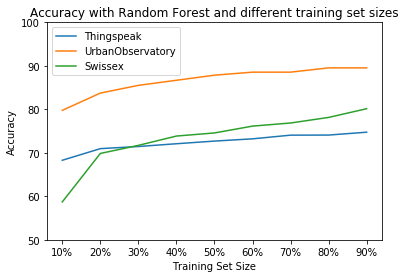

In [113]:
plt.plot(labels, acc_things, label='Thingspeak')
plt.plot(labels, acc_urban, label='UrbanObservatory')
plt.plot(labels, acc_swissex, label='Swissex')
plt.axis([-0.4, 8.4, 50, 100])
plt.title('Accuracy with Random Forest and different training set sizes')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()

In [109]:
acc_things

[68.28638497652581,
 70.962441314554,
 71.45539906103286,
 72.08920187793427,
 72.69953051643192,
 73.21596244131456,
 74.06103286384976,
 74.08450704225352,
 74.74178403755869]

In [110]:
acc_swissex

[58.71428571428571,
 69.85714285714286,
 71.71428571428571,
 73.85714285714286,
 74.57142857142858,
 76.14285714285714,
 76.85714285714286,
 78.14285714285714,
 80.14285714285714]

In [111]:
acc_urban

[79.76635514018692,
 83.73831775700936,
 85.5140186915888,
 86.6822429906542,
 87.85046728971962,
 88.55140186915888,
 88.5514018691589,
 89.53271028037382,
 89.53271028037383]